In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
import glob
import h5py
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import pickle
import quantities as pq

In [3]:
import epych
import epych.recording as recording

In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
def epoch_intervals(intervals, epoch):
    mask = intervals[epoch][:].astype(bool)
    return np.stack((intervals['start_time'][mask], intervals['stop_time'][mask]), axis=-1)

In [7]:
def trial_intervals(intervals):
    trial_nums = intervals['trial_num'][:].astype(int)
    trials = np.unique(trial_nums)
    startstops = []
    for trial in trials:
        indices = np.nonzero(trial_nums == trial)[0]
        startstops.append((intervals['start_time'][indices[0]], intervals['stop_time'][indices[-1]]))
    return np.array(startstops)

In [8]:
def trial_stimulus_intervals(intervals):
    trial_nums = intervals['trial_num'][:].astype(int)
    trials = np.unique(trial_nums)
    stimuli = {k: [] for k in range(5)}
    for trial in trials:
        for index, interval in enumerate(np.nonzero(trial_nums == trial)[0]):
            stimuli[index].append((intervals['start_time'][interval], intervals['stop_time'][interval]))
    return {k: np.array(v) for k, v in stimuli.items()}

In [9]:
CONDITIONS = ["go_gloexp", "lo_gloexp", "go_seqctl", "seqctl"]
PRETRIAL_SECONDS = 0.5
POSTTRIAL_SECONDS = 0.5

In [10]:
NWB_FILES = glob.glob('/mnt/data/*.nwb')

In [11]:
CONDITION = CONDITIONS[0]
NWB_FILE  = NWB_FILES[-1]

In [12]:
nwb = h5py.File(NWB_FILE, 'r')
electrodes = nwb['general']['extracellular_ephys']['electrodes']
probes = sorted([probe.decode() for probe in set(electrodes['group_name'][:])])
glo_intervals = nwb['intervals']['passive_glo']

In [13]:
signals = {}

In [14]:
for p, probe in enumerate(probes):
    probe_lfp = "probe_%d_lfp" % p
    probe_lfp = probe_lfp + "/" + probe_lfp + "_data"
    probe_lfps = nwb['acquisition/'][probe_lfp]
    timestamps = probe_lfps["timestamps"][:]
    dt = (timestamps[1:] - timestamps[:-1]).mean()
    probe_data = np.transpose(probe_lfps["data"])[:, :, np.newaxis]

    probe_electrodes = electrodes["group_name"][:] == probe.encode()
    channels = {
        "horizontal": electrodes["probe_horizontal_position"][probe_electrodes],
        "id": electrodes["id"][probe_electrodes],
        "location": electrodes["location"][probe_electrodes],
        "vertical": electrodes["probe_vertical_position"][probe_electrodes],
    }
    channels = {k: v[probe_lfps['electrodes'][:]] for k, v in channels.items()}
    probe_channels = pd.DataFrame(data=channels, columns=["horizontal", "location", "vertical"], index=channels['id'])
    assert probe_data.shape[0] == len(probe_channels)

    signals[probe] = epych.signals.lfp.ContinuousLfp(probe_channels, probe_data, dt, timestamps)

In [15]:
epochs = {
    "start": np.array([]),
    "end": np.array([]),
    "type": [],
}

In [16]:
trials = trial_intervals(glo_intervals)
trial_times = trials[:, 0]
epochs["start"] = np.concatenate((epochs["start"], trials[:, 0]), axis=0)
epochs["end"] = np.concatenate((epochs["end"], trials[:, 1]), axis=0)
epochs["type"] = epochs["type"] + ["trial"] * trials.shape[0]

In [17]:
cond_times = epoch_intervals(glo_intervals, CONDITION)
epochs["start"] = np.concatenate((epochs["start"], cond_times[:, 0]), axis=0)
epochs["end"] = np.concatenate((epochs["end"], cond_times[:, 1]), axis=0)
epochs["type"] = epochs["type"] + [CONDITION] * cond_times.shape[0]

In [18]:
cond_times = epoch_intervals(glo_intervals, "lo_gloexp")
epochs["start"] = np.concatenate((epochs["start"], cond_times[:, 0]), axis=0)
epochs["end"] = np.concatenate((epochs["end"], cond_times[:, 1]), axis=0)
epochs["type"] = epochs["type"] + ["lo_gloexp"] * cond_times.shape[0]

In [19]:
stim_times = trial_stimulus_intervals(glo_intervals)
for k, v in stim_times.items():
    epochs["start"] = np.concatenate((epochs["start"], v[:, 0]), axis=0)
    epochs["end"] = np.concatenate((epochs["end"], v[:, 1]), axis=0)
    epochs["type"] = epochs["type"] + ["stim%d" % k] * v.shape[0]

In [20]:
units = {"start": pq.second, "end": pq.second}
epochs = pd.DataFrame(data=epochs, columns=epochs.keys())

In [21]:
recording = recording.Recording(epochs, pd.DataFrame(columns=["trial"]).set_index("trial"), units, **signals)

In [22]:
condition_epochs = recording.intervals["type"] == CONDITION
trial_epochs = recording.intervals["type"] == "trial"

In [23]:
go_sampling = recording.epoch(condition_epochs, trial_epochs, PRETRIAL_SECONDS, POSTTRIAL_SECONDS).baseline_correct(0, PRETRIAL_SECONDS)

In [24]:
oddball_onset = go_sampling.trials['go_gloexp_start'].mean()
oddball_offset = go_sampling.trials['go_gloexp_end'].mean()

evenball_onset = go_sampling.trials['stim2_start'].mean()
evenball_offset = go_sampling.trials['stim2_end'].mean()

unadapted_onset = go_sampling.trials['stim0_start'].mean()
unadapted_offset = go_sampling.trials['stim0_end'].mean()

In [25]:
erp = go_sampling.erp()

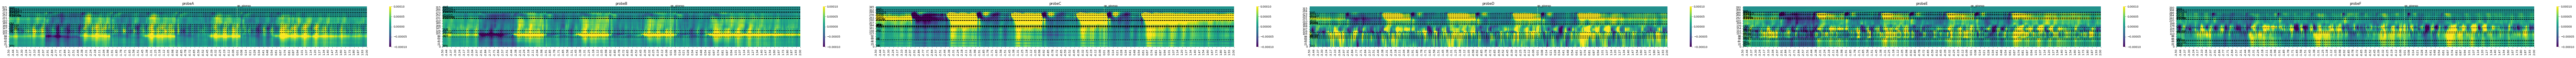

In [26]:
erp.plot(vmin=-1e-4, vmax=1e-4, go_gloexp=oddball_onset)

In [27]:
csd = erp.smap(lambda sig: sig.downsample(4).current_source_density())

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


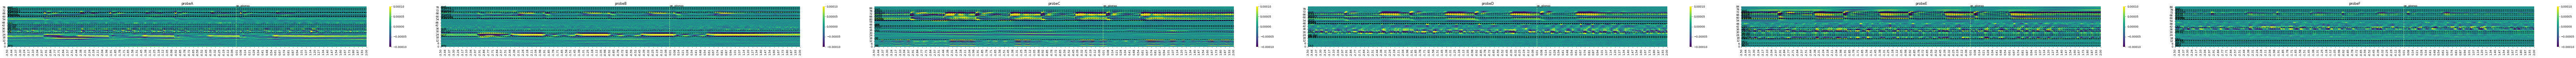

In [28]:
csd.plot(vmin=-1e-4, vmax=1e-4, go_gloexp=oddball_onset)

In [29]:
oddball = go_sampling[oddball_onset:oddball_offset]
evenball = go_sampling[evenball_onset:evenball_offset]
unadapted = go_sampling[unadapted_onset:unadapted_offset]
go_contrast = oddball - evenball
go_adaptation = evenball - unadapted

In [30]:
erp = go_contrast.erp()

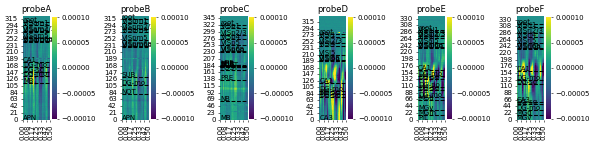

In [31]:
erp.plot(vmin=-1e-4, vmax=1e-4)

In [32]:
erp = go_adaptation.erp()

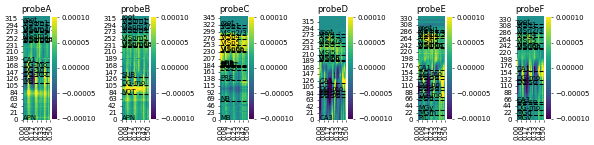

In [33]:
erp.plot(vmin=-1e-4, vmax=1e-4)

In [34]:
oddball = csd[oddball_onset:oddball_offset]
evenball = csd[evenball_onset:evenball_offset]
unadapted = csd[unadapted_onset:unadapted_offset]
gocsd_contrast = oddball - evenball
gocsd_adaptation = evenball - unadapted

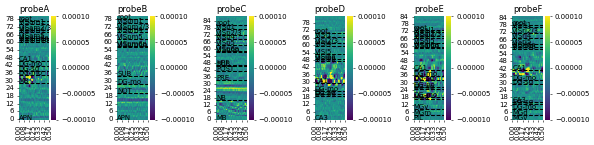

In [35]:
gocsd_contrast.plot(vmin=-1e-4, vmax=1e-4)

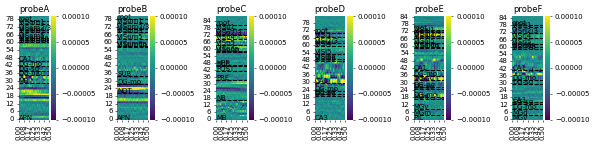

In [36]:
gocsd_adaptation.plot(vmin=-1e-4, vmax=1e-4)

In [37]:
condition_epochs = recording.intervals["type"] == "lo_gloexp"
trial_epochs = recording.intervals["type"] == "trial"

In [38]:
lo_sampling = recording.epoch(condition_epochs, trial_epochs, PRETRIAL_SECONDS, POSTTRIAL_SECONDS).baseline_correct(0, PRETRIAL_SECONDS)

In [39]:
oddball_onset = lo_sampling.trials['lo_gloexp_start'].mean()
oddball_offset = lo_sampling.trials['lo_gloexp_end'].mean()

evenball_onset = lo_sampling.trials['stim2_start'].mean()
evenball_offset = lo_sampling.trials['stim2_end'].mean()

unadapted_onset = lo_sampling.trials['stim0_start'].mean()
unadapted_offset = lo_sampling.trials['stim0_end'].mean()

In [40]:
erp = lo_sampling.erp()

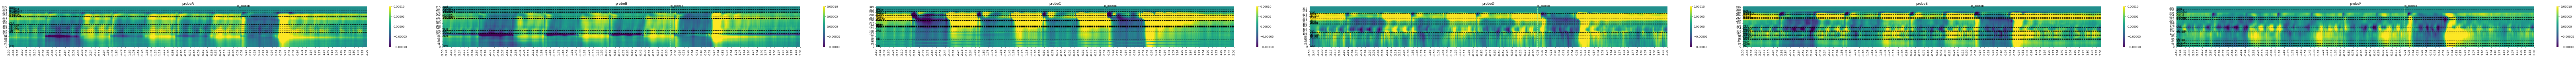

In [41]:
erp.plot(vmin=-1e-4, vmax=1e-4, lo_gloexp=oddball_onset)

In [42]:
csd = erp.smap(lambda sig: sig.downsample(4).current_source_density())

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


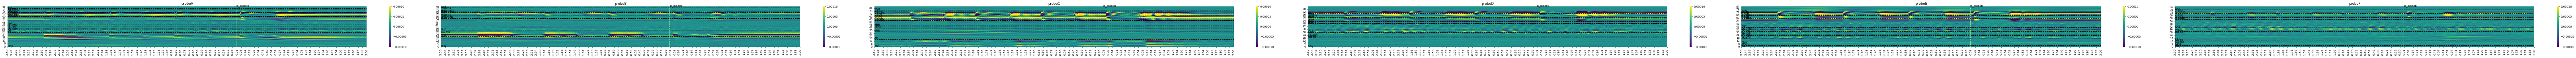

In [43]:
csd.plot(vmin=-1e-4, vmax=1e-4, lo_gloexp=oddball_onset)

In [44]:
oddball = lo_sampling[oddball_onset:oddball_offset]
evenball = lo_sampling[evenball_onset:evenball_offset]
unadapted = lo_sampling[unadapted_onset:unadapted_offset]
lo_contrast = oddball - evenball
lo_adaptation = evenball - unadapted

In [45]:
erp = lo_contrast.erp()

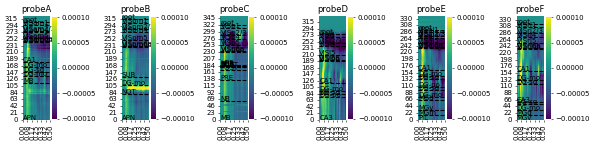

In [46]:
erp.plot(vmin=-1e-4, vmax=1e-4)

In [47]:
erp = lo_adaptation.erp()

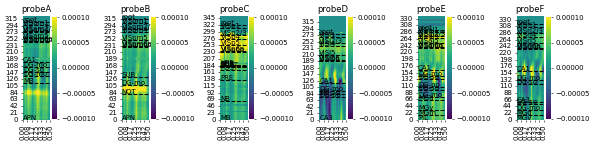

In [48]:
erp.plot(vmin=-1e-4, vmax=1e-4)

In [49]:
oddball = csd[oddball_onset:oddball_offset]
evenball = csd[evenball_onset:evenball_offset]
unadapted = csd[unadapted_onset:unadapted_offset]
locsd_contrast = oddball - evenball
locsd_adaptation = evenball - unadapted

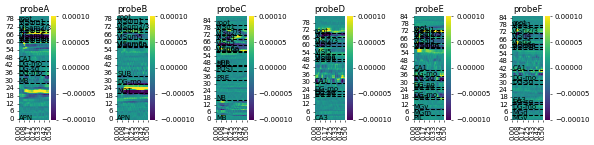

In [50]:
locsd_contrast.plot(vmin=-1e-4, vmax=1e-4)

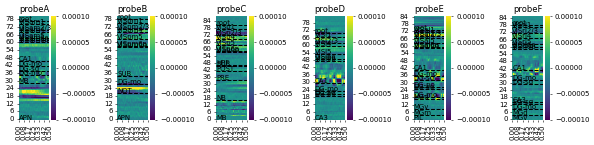

In [51]:
locsd_adaptation.plot(vmin=-1e-4, vmax=1e-4)

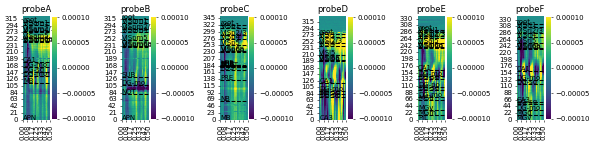

In [52]:
(go_contrast.erp() - lo_contrast.erp()).plot(vmin=-1e-4, vmax=1e-4, figure="go_vs_lo_contrast.pdf")